In [1]:
# Import dependencies
# Database Dependencies
import pymongo
import gridfs
import pandas as pd
import io
import numpy as np
from PIL import Image, ImageOps
import subprocess
from config import DB_NAME, FEAT_3_COLLECTION_NAME, FEAT_30_COLLECTION_NAME

# Machine Learning Dependencies
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import matplotlib.pyplot as plt

# Neural Network Dependencies
import tensorflow as tf
from tensorflow import keras

# Database Connection and Loading Data

In [2]:
# Establish mongo instance and get Music database
client = pymongo.MongoClient('localhost')
db = client[DB_NAME]

In [3]:
# Select 'features_3_sec' collection, and read in as pandas DataFrame
collection = db[FEAT_3_COLLECTION_NAME].find()
features_3_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_3_df = features_3_df.drop(columns = ["_id"])
features_3_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [4]:
cwd_bytes = subprocess.check_output("pwd")
cwd = cwd_bytes.decode("utf-8").rstrip("\n") + "/"

In [5]:
# identify path for images
images_path = "Data/images_original/"

In [6]:
byte_images = subprocess.check_output(["ls", cwd + images_path])
images_folder = byte_images.decode("utf-8").split("\n")
images_folder.pop(-1)

''

In [7]:
# Establish the gridfs instance
fs = gridfs.GridFS(db)

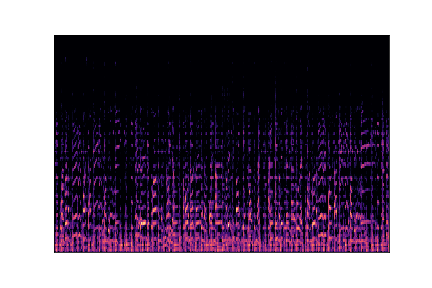

In [8]:
# Single Image Test
test_raw = fs.get_last_version("Data/images_original/blues/blues00000.png")
test_bytes = test_raw.read()
rgba_test = Image.open(io.BytesIO(test_bytes))
# RGBA Image (default)
rgba_test

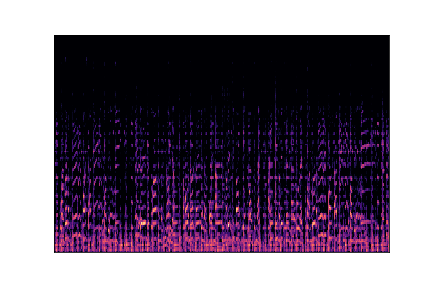

In [9]:
# Converting RGBA TO RGB
rgb_test = rgba_test.convert("RGB")
rgb_test

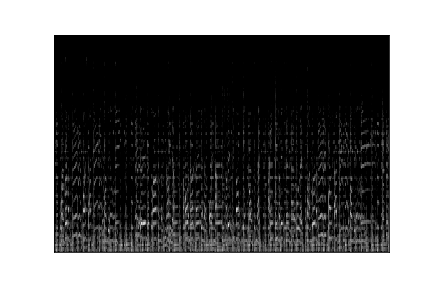

In [10]:
# Converting RGB to Grayscale
gray_test = ImageOps.grayscale(rgb_test)
gray_test

In [11]:
# Convert image to numpy array with pixel values
np.asarray(gray_test)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [12]:
# Replicate single image loading/conversion to grayscale for all images
images = []
genres = []

for folder in images_folder:
    # Get files in each image-genre folder
    byte_files = subprocess.check_output(["ls", cwd + images_path + folder])
    files = byte_files.decode("utf-8").split("\n")
    files.pop(-1)
    
    for file in files:
        # Load image using its relative path as its GridFS identifier
        file_path = images_path + folder + "/" + file
        image_raw = fs.get_last_version(file_path)
        image_bytes = image_raw.read()
        rgba_image = Image.open(io.BytesIO(image_bytes))
        rgb_image = rgba_image.convert("RGB")
        gray_image = ImageOps.grayscale(rgb_image)
        image_data = np.asarray(gray_image)
        images.append(image_data)
        genres.append(folder)

In [13]:
# Convert image/genre lists to numpy arrays
images = np.asarray(images)
genres = np.asarray(genres)

In [14]:
print(images.shape)
print(genres.shape)

(999, 288, 432)
(999,)


In [15]:
images[0].shape

(288, 432)

In [16]:
genres[0]

'blues'

# Build, Train, and Test Models to Predict `label` from feature data

## `DecisionTreeClassifier`

In [44]:
# Separate Features (X) from the Target (y)
y = features_3_df["label"]
X = features_3_df.drop(columns="label", axis=1)

In [45]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
9986,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
9987,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990
9988,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,4.123402,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750


In [46]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [47]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [48]:
# Instantitae DecisionTreeClassifier
tree_model = DecisionTreeClassifier()

# Fit the model
tree_model = tree_model.fit(X_train, y_train)

# Make predictions using the testing data
tree_pred = tree_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": tree_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,8,8
1,8,8
2,9,9
3,6,0
4,6,9
...,...,...
2493,1,1
2494,7,3
2495,2,2
2496,0,0


In [49]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, tree_pred)
cm

array([[145,   3,  26,  11,   6,   8,  14,   2,   8,  13],
       [  4, 218,   6,   1,   0,  14,   1,   0,   0,   3],
       [ 35,  11, 138,  13,   7,  20,   7,   8,   8,  16],
       [  6,   1,   7, 138,  14,   3,  11,  19,  18,  12],
       [  9,   2,   6,  19, 169,   2,  12,  24,  16,   3],
       [ 15,  19,  22,   4,   2, 155,   8,   2,   4,  20],
       [  7,   1,   5,  11,  14,   2, 194,   2,   4,  19],
       [  2,   2,   7,  15,  14,   4,   1, 165,  18,  14],
       [  7,   3,   5,  11,  21,   9,   3,  14, 178,  14],
       [ 20,   7,  18,  20,  11,  13,  17,  10,  17, 111]])

In [50]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, tree_pred)
acc_score

0.644915932746197

In [51]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           0       0.58      0.61      0.60       236
           1       0.82      0.88      0.85       247
           2       0.57      0.52      0.55       263
           3       0.57      0.60      0.58       229
           4       0.66      0.65      0.65       262
           5       0.67      0.62      0.64       251
           6       0.72      0.75      0.74       259
           7       0.67      0.68      0.68       242
           8       0.66      0.67      0.66       265
           9       0.49      0.45      0.47       244

    accuracy                           0.64      2498
   macro avg       0.64      0.64      0.64      2498
weighted avg       0.64      0.64      0.64      2498



## `KNN`

In [52]:
# Instantiate SVM
knn_model = KNeighborsClassifier(n_neighbors=21)

# Fit the model
knn_model = knn_model.fit(X_train, y_train)

# Make predicitions using the testing data
knn_pred = knn_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": knn_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,9,8
1,1,8
2,3,9
3,6,0
4,6,9
...,...,...
2493,1,1
2494,2,3
2495,3,2
2496,9,0


In [53]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, knn_pred)
cm

array([[ 33,  14,  25,  26,  19,  43,  41,   9,  11,  15],
       [ 11, 168,   7,   1,   0,  16,  38,   0,   4,   2],
       [ 22,  17,  49,  44,  12,  26,  28,  16,  28,  21],
       [ 26,   2,  20,  52,  33,   4,  18,  21,  27,  26],
       [ 10,   2,  16,  43,  40,   1,  22,  59,  54,  15],
       [ 35,  24,  34,  20,   6,  54,  34,  14,  10,  20],
       [ 25,  31,  23,  21,  10,  11, 112,   0,   4,  22],
       [  7,   3,  10,  30,  39,  14,   5,  91,  38,   5],
       [ 11,   3,  26,  33,  23,   7,  17,  45,  89,  11],
       [ 20,  12,  37,  44,  22,  22,  32,  17,  21,  17]])

In [54]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, knn_pred)
acc_score

0.2822257806244996

In [55]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.17      0.14      0.15       236
           1       0.61      0.68      0.64       247
           2       0.20      0.19      0.19       263
           3       0.17      0.23      0.19       229
           4       0.20      0.15      0.17       262
           5       0.27      0.22      0.24       251
           6       0.32      0.43      0.37       259
           7       0.33      0.38      0.35       242
           8       0.31      0.34      0.32       265
           9       0.11      0.07      0.09       244

    accuracy                           0.28      2498
   macro avg       0.27      0.28      0.27      2498
weighted avg       0.27      0.28      0.27      2498



## Naive-Bayes Classifier

In [56]:
# Instantiate the model
gnb_model = GaussianNB()

# Fit the model
gnb_model = gnb_model.fit(X_train, y_train)

# Make predicitions using the testing data
gnb_pred = gnb_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": gnb_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,3,8
1,7,8
2,4,9
3,6,0
4,6,9
...,...,...
2493,5,1
2494,3,3
2495,9,2
2496,6,0


In [57]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, gnb_pred)
cm

array([[ 56,  14,  33,   4,   1,  28,  78,   0,  16,   6],
       [  1, 220,   2,   0,   0,   8,  10,   1,   3,   2],
       [ 16,  15,  84,  37,   4,   8,  59,   1,  22,  17],
       [  8,   2,   7,  92,   9,   2,  76,   6,  16,  11],
       [  7,   0,  25,  47,  62,   1,  50,  23,  42,   5],
       [ 22,  53,  12,  26,   0,  55,  48,   6,   6,  23],
       [  1,   1,   1,  10,   7,   0, 232,   1,   2,   4],
       [  1,   2,   6,  57,  10,   3,  19, 116,  23,   5],
       [ 25,   1,  31,  30,  22,   1,   7,  19, 121,   8],
       [  3,  12,  25,  36,  11,   2, 108,   4,  18,  25]])

In [58]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, gnb_pred)
acc_score

0.4255404323458767

In [59]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           0       0.40      0.24      0.30       236
           1       0.69      0.89      0.78       247
           2       0.37      0.32      0.34       263
           3       0.27      0.40      0.32       229
           4       0.49      0.24      0.32       262
           5       0.51      0.22      0.31       251
           6       0.34      0.90      0.49       259
           7       0.66      0.48      0.55       242
           8       0.45      0.46      0.45       265
           9       0.24      0.10      0.14       244

    accuracy                           0.43      2498
   macro avg       0.44      0.42      0.40      2498
weighted avg       0.44      0.43      0.40      2498



## `RandomForestClassifier`

In [60]:
# Instantiate the model
rf_model = RandomForestClassifier(n_estimators=500)

# Fit the model
rf_model = rf_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_pred = rf_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,8,8
1,8,8
2,9,9
3,0,0
4,6,9
...,...,...
2493,1,1
2494,3,3
2495,2,2
2496,0,0


In [61]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_pred)
cm

array([[218,   0,   4,   4,   1,   4,   4,   0,   0,   1],
       [  0, 238,   2,   0,   0,   6,   0,   0,   0,   1],
       [ 10,   2, 228,   3,   0,   8,   2,   0,   9,   1],
       [  3,   3,   4, 198,   4,   1,   2,   3,   5,   6],
       [  1,   1,   3,   8, 218,   0,   5,  17,   5,   4],
       [  6,  11,   8,   2,   0, 224,   0,   0,   0,   0],
       [  1,   0,   1,   3,   5,   1, 238,   0,   1,   9],
       [  0,   2,  12,   5,   6,   0,   0, 206,   7,   4],
       [  2,   2,   6,   3,   5,   2,   0,   8, 236,   1],
       [  6,   4,  11,  12,   2,   7,  12,   0,   6, 184]])

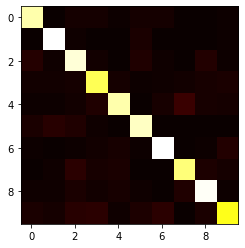

In [62]:
plt.imshow(cm, cmap='hot', interpolation='nearest')
plt.show()

In [63]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_pred)
acc_score

0.8759007205764612

In [64]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       236
           1       0.90      0.96      0.93       247
           2       0.82      0.87      0.84       263
           3       0.83      0.86      0.85       229
           4       0.90      0.83      0.87       262
           5       0.89      0.89      0.89       251
           6       0.90      0.92      0.91       259
           7       0.88      0.85      0.87       242
           8       0.88      0.89      0.88       265
           9       0.87      0.75      0.81       244

    accuracy                           0.88      2498
   macro avg       0.88      0.88      0.88      2498
weighted avg       0.88      0.88      0.88      2498



# Build, Train, and Test Neural Network to Predict `label` from Images

In [65]:
X = np.copy(images)
y = np.copy(genres)

In [67]:
y = np.vectorize(genre_nums.get)(y)

In [68]:
# Encode class labels in target y
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [69]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(749, 288, 432)
(250, 288, 432)
(749,)
(250,)


In [70]:
# Normalize pixel data:
X_train = X_train / 255
X_test = X_test / 255

In [71]:
# Define Neural Net
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[288, 432]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")])

In [72]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 124416)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               37325100  
_________________________________________________________________
dense_6 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 37,376,410
Trainable params: 37,376,410
Non-trainable params: 0
__________________________________________

In [73]:
# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [77]:
# Train the model
history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
24/24 [==============================] - 3s 110ms/step - loss: 1.9632 - accuracy: 0.2697
Epoch 2/200
24/24 [==============================] - 3s 110ms/step - loss: 2.0453 - accuracy: 0.2310
Epoch 3/200
24/24 [==============================] - 3s 110ms/step - loss: 2.0348 - accuracy: 0.2523
Epoch 4/200
24/24 [==============================] - 3s 109ms/step - loss: 1.9996 - accuracy: 0.2403
Epoch 5/200
24/24 [==============================] - 3s 110ms/step - loss: 1.9864 - accuracy: 0.2537
Epoch 6/200
24/24 [==============================] - 3s 110ms/step - loss: 2.0154 - accuracy: 0.2363
Epoch 7/200
24/24 [==============================] - 3s 110ms/step - loss: 1.9885 - accuracy: 0.2563
Epoch 8/200
24/24 [==============================] - 3s 110ms/step - loss: 1.9402 - accuracy: 0.2563
Epoch 9/200
24/24 [==============================] - 3s 110ms/step - loss: 1.9924 - accuracy: 0.2644
Epoch 10/200
24/24 [==============================] - 3s 110ms/step - loss: 2.0069 - accura

24/24 [==============================] - 3s 110ms/step - loss: 1.8007 - accuracy: 0.3431
Epoch 161/200
24/24 [==============================] - 3s 110ms/step - loss: 1.7379 - accuracy: 0.3351
Epoch 162/200
24/24 [==============================] - 3s 110ms/step - loss: 1.8240 - accuracy: 0.3191
Epoch 163/200
24/24 [==============================] - 3s 110ms/step - loss: 1.7505 - accuracy: 0.3591
Epoch 164/200
24/24 [==============================] - 3s 110ms/step - loss: 1.7915 - accuracy: 0.3271
Epoch 165/200
24/24 [==============================] - 3s 109ms/step - loss: 1.8119 - accuracy: 0.3191
Epoch 166/200
24/24 [==============================] - 3s 109ms/step - loss: 1.9016 - accuracy: 0.3298
Epoch 167/200
24/24 [==============================] - 3s 110ms/step - loss: 1.7853 - accuracy: 0.3258
Epoch 168/200
24/24 [==============================] - 3s 109ms/step - loss: 1.7857 - accuracy: 0.3311
Epoch 169/200
24/24 [==============================] - 3s 109ms/step - loss: 1.8550 - a

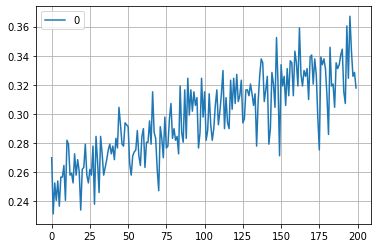

In [80]:
# Plot training results
pd.DataFrame(history.history["accuracy"]).plot()
plt.grid(True)
plt.show()

In [82]:
# Evaluate model
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 24ms/step - loss: 1.8947 - accuracy: 0.2920


[1.8946644067764282, 0.2919999957084656]